# Time series analysis with ARIMA. 


##  Total Passengers Estimatimations in AENA Airports Networks.

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required.

We will aim to produce reliable forecasts of time series. We will begin by introducing and discussing the concepts of autocorrelation, stationarity, and seasonality, and proceed to apply one of the most commonly used method for time-series forecasting, known as ARIMA.

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

## Import libraries and get sample data

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('fivethirtyeight')

In [2]:
# Load the data

data = pd.read_csv('data/paxAena.csv', sep=';', engine='python')

# A bit of pre-processing to make it nicer

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index(['Date'], inplace=True)

data.tail()

,Pax
Date,
2018-08-01,28346258
2018-09-01,26242088
2018-10-01,24326839
2018-11-01,17718779
2018-12-01,17604821


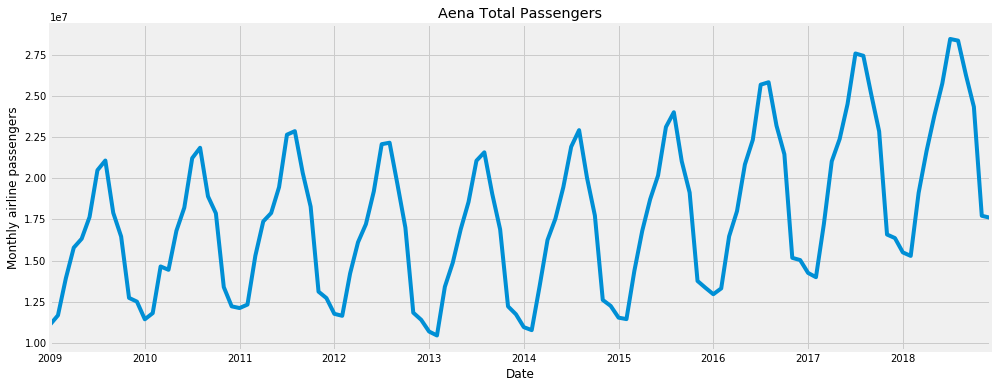

In [3]:
# Plot Total Passengers

data['Pax'].plot(figsize=(15, 6))
plt.ylabel('Monthly airline passengers')
plt.xlabel('Date')
plt.title('Aena Total Passengers')
plt.show()

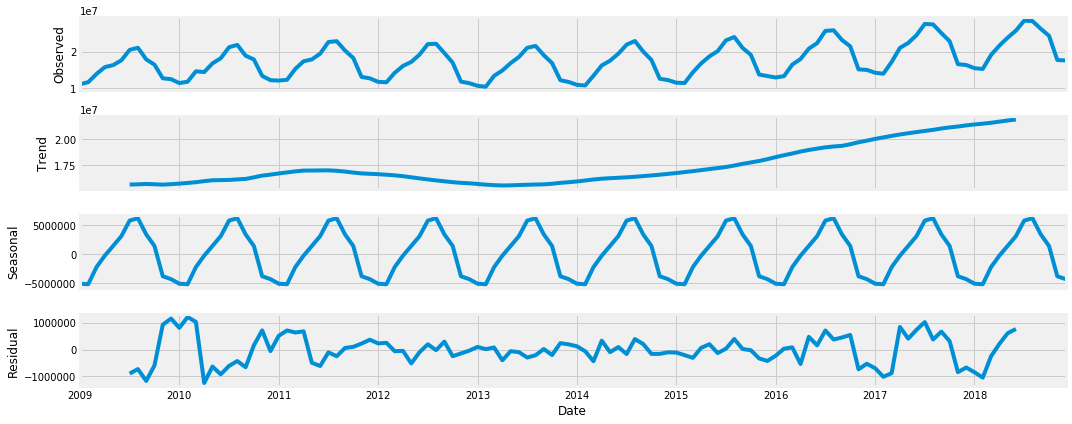

In [4]:
# Clasical componets in Time Series. Trend, Seasonal and Residual

from pylab import rcParams
rcParams['figure.figsize'] = (15, 6)

components = sm.tsa.seasonal_decompose(data, model='additive')
components.plot()
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern hemisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

In this case it is clear that s=12.

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself. So that is the way to obtain (p, d, q) and (P, D, Q) parameters.

In [5]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say 2 years. Our goal is to predict the year 2019.

In [6]:
train_data = data['2009-01-01':'2017-12-01']
test_data = data['2018-01-01':'2018-12-01']

In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
models = pd.DataFrame([SARIMAX_model, AIC]).T
models.columns = ["Model", "AIC"]

models.sort_values("AIC", inplace=True, ascending=True)
models

,Model,AIC
238,"[(3, 1, 0), (3, 1, 0, 12)]",1632.14
254,"[(3, 1, 1), (3, 1, 0, 12)]",1633.79
239,"[(3, 1, 0), (3, 1, 1, 12)]",1634.07
255,"[(3, 1, 1), (3, 1, 1, 12)]",1635.72
190,"[(2, 1, 1), (3, 1, 0, 12)]",1660.07
...,...,...
32,"[(0, 1, 0), (0, 0, 0, 12)]",3415.91
64,"[(1, 0, 0), (0, 0, 0, 12)]",3448.87
176,"[(2, 1, 1), (0, 0, 0, 12)]",3527.35
16,"[(0, 0, 1), (0, 0, 0, 12)]",3766.64


In [9]:
# lowest AIC
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(models.iloc[0, 1], \
                                models.iloc[0, 0][0], models.iloc[0, 0][1]))

The smallest AIC is 1632.1409739880794 for model SARIMAX(3, 1, 0)x(3, 1, 0, 12)


In [10]:
SARIMAX_model[AIC.index(min(AIC))]

[(3, 1, 0), (3, 1, 0, 12)]

In [11]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=models.iloc[0, 0][0],
                                seasonal_order=models.iloc[0, 0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [12]:
results.summary()#.tables[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                Pax   No. Observations:                  108
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -809.070
Date:                            Sat, 21 Dec 2019   AIC                           1632.141
Time:                                    19:18:22   BIC                           1646.318
Sample:                                01-01-2009   HQIC                          1637.638
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3614      0.321     -1.125      0.260      -0.991       0.268
ar.L2         -0.0772      0.311     -0.248      0.804      -0.686       0.532
ar.L3          0.1174      0.260      0.452      0.651      -0.391       0.626
ar.S.L12      -0.3647      0.286     -1.273      0.203      -0.926       0.197
ar.S.L24      -0.3092      0.289     -1.069      0.285      -0.876       0.258
ar.S.L36       0.2480      0.185      1.341      0.180      -0.114       0.611
sigma2      3.118e+11   3.31e-13   9.43e+23      0.000    3.12e+11    3.12e+11
===================================================================================
Ljung-Box (Q):                       37.07   Jarque-Bera (JB):                11.69
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.45
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.35e+39. Standard errors may be unstable.
"""

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

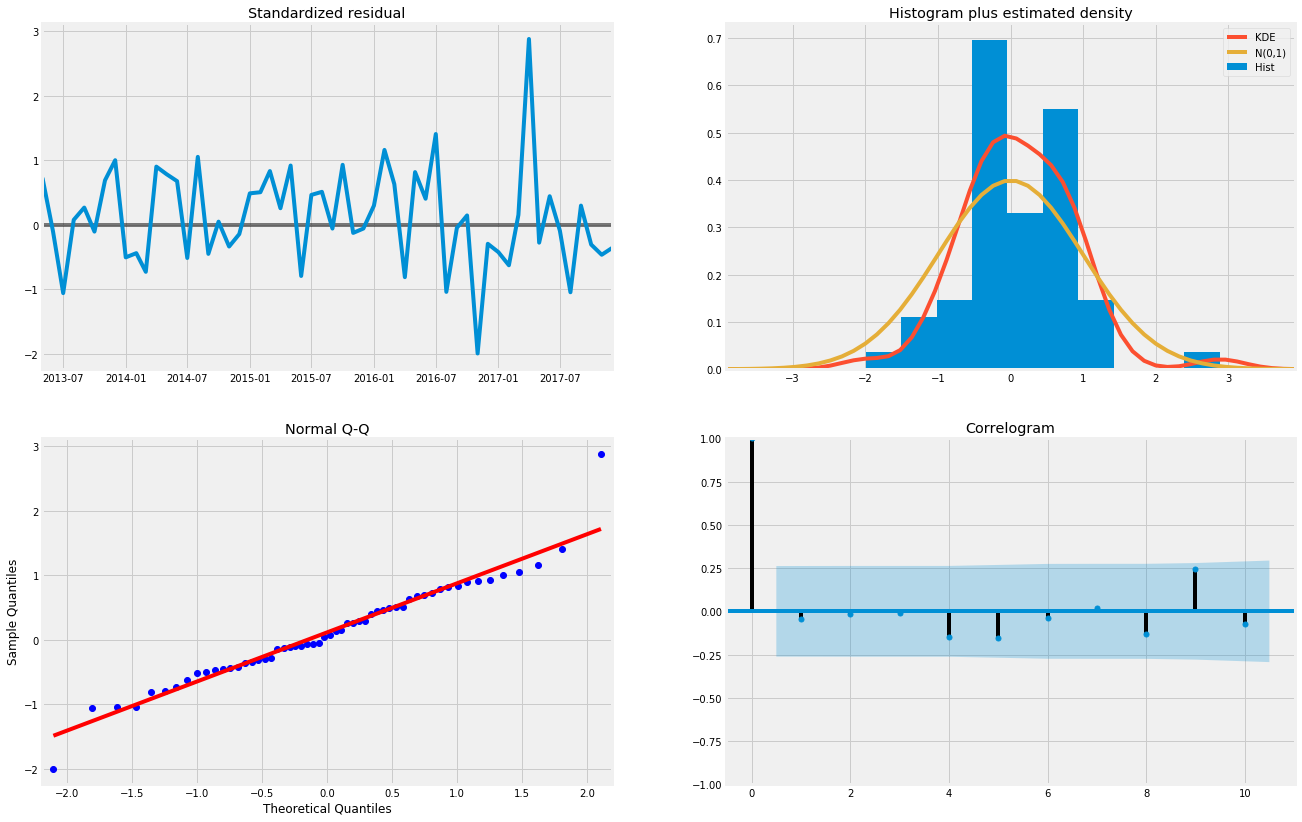

In [13]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

In [14]:
pred0 = results.get_prediction(start='2017-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (2018). Again, the model is used to predict data that the model was built on.

In [15]:
pred1 = results.get_prediction(start='2018-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before, that is 2019.

In [16]:
pred2 = results.get_forecast('2019-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2019-01-01':'2019-12-01'])

2019-01-01    1.722255e+07
2019-02-01    1.731347e+07
2019-03-01    2.055636e+07
2019-04-01    2.303145e+07
2019-05-01    2.532522e+07
2019-06-01    2.703848e+07
2019-07-01    3.035428e+07
2019-08-01    3.031310e+07
2019-09-01    2.781671e+07
2019-10-01    2.591831e+07
2019-11-01    1.956045e+07
2019-12-01    1.939395e+07
Freq: MS, dtype: float64


Let's plot all this

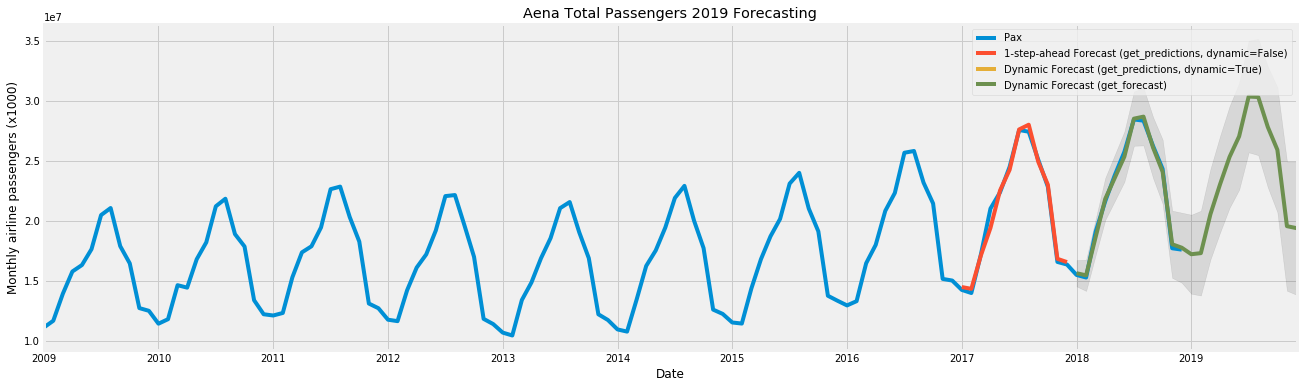

In [17]:
ax = data.plot(figsize=(20, 6))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.title('Aena Total Passengers 2019 Forecasting')
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample prediction.

In order to quantify the accuracy of the prediction for 2018, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE).

In [20]:
prediction = pred2.predicted_mean['2018-01-01':'2018-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))

# Mean Absolute Percentage Error
RMSE = np.sqrt(np.square(prediction - truth)).mean()
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))
print('The Mean Absolute Percentage Error for the forecast of year 2018 is {:.2f}%'.format(MAPE))

The Root Mean Squared Error of our forecasts is 237286.34
The Mean Absolute Percentage Error for the forecast of year 2018 is 1.13%
